In [7]:
!pip install jcopdl==1.1.1

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12587 sha256=8094a016c2354551fe82e473ef9aa1a3f4cf76b0106dc0383c269ccac3e73b44
  Stored in directory: /root/.cache/pip/wheels/6d/46/c4/fbd4a6c344375a840af6eb98af862a0b12da406d4fbc2aa882
Successfully built jcopdl
  Attempting uninstall: jcopdl
    Found existing installation: jcopdl 2.3.3
    Uninstalling jcopdl-2.3.3:
      Successfully uninstalled jcopdl-2.3.3


In [2]:
!pip install gdown

In [3]:
!gdown https://drive.google.com/uc?id=1aPgQGEWnekL4MwhfoQIUUs8m2cT1Coon

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1aPgQGEWnekL4MwhfoQIUUs8m2cT1Coon

but Gdown can't. Please check connections and permissions.


In [2]:
!unzip -q data.zip

replace data/test_label.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & Dataloader

In [5]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from jcopdl.utils.dataloader import MultilabelDataset

bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224), # ikuti model mobilenet v2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # mengikuti aturan model mobile net v2
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur & Config

## Contoh cara pakai pretrained-model

In [7]:
from torchvision.models import mobilenet_v2

In [8]:
mnet = mobilenet_v2(weights=True)

# membekukan weight dari model mobilenet v2
for param in mnet.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 52.9MB/s]


In [ ]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

In [9]:
# menimpa layer terakhir dari model mobilevnet2 menyesuaikan dengan label kita
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [ ]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(weights=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True


In [12]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

## Phase 1: Adaptation (lr standard + patience kecil)

In [13]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2 ,outdir="model")

In [16]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]

    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.2738 | Test_cost  = 0.2612 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.2661 | Test_cost  = 0.2579 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2485 | Test_cost  = 0.2482 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2543 | Test_cost  = 0.2403 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2355 | Test_cost  = 0.2369 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.2274 | Test_cost  = 0.2412 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2369


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2267 | Test_cost  = 0.2234 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2218 | Test_cost  = 0.2204 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.2212 | Test_cost  = 0.2213 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2204


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2166 | Test_cost  = 0.2160 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2085 | Test_cost  = 0.2182 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2160


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2057 | Test_cost  = 0.2141 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2030 | Test_cost  = 0.2320 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2141


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2110 | Test_cost  = 0.2100 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.2077 | Test_cost  = 0.2242 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2100


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.2154 | Test_cost  = 0.2116 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2100
==> Execute Early Stopping at epoch: 16 | Best test_cost: 0.2100
==> Best model is saved at model


/usr/local/lib/python3.10/dist-packages/jcopdl/callback/_callback.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f'{self.outdir}/weights_best.pth

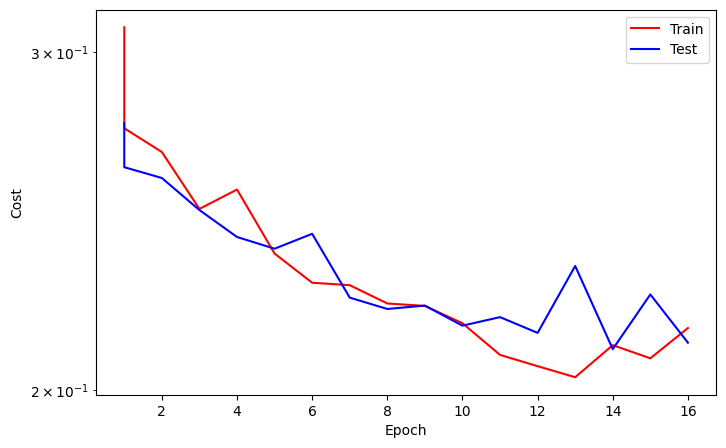

In [20]:
while True:
    train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break



## Phase 2: Fine-tuning (lr dikecilin, patience ditambah)

In [21]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1940 | Test_cost  = 0.2039 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1739 | Test_cost  = 0.1930 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1630 | Test_cost  = 0.1913 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.1539 | Test_cost  = 0.1880 | 


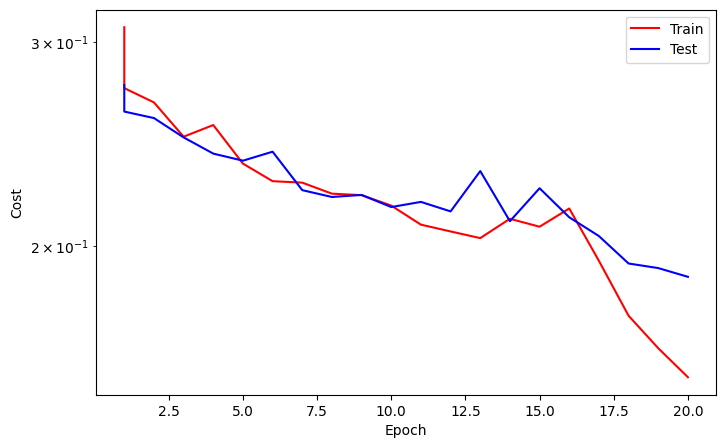

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1527 | Test_cost  = 0.1852 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1391 | Test_cost  = 0.1810 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1390 | Test_cost  = 0.1756 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.1324 | Test_cost  = 0.1808 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1756


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.1233 | Test_cost  = 0.1797 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1756


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
if w.is_alive():    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.1197 | Test_cost  = 0.1700 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.1222 | Test_cost  = 0.1715 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1700


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.1158 | Test_cost  = 0.1716 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1700


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.1124 | Test_cost  = 0.1667 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.1075 | Test_cost  = 0.1642 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.1041 | Test_cost  = 0.1657 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1642


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.1050 | Test_cost  = 0.1638 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0990 | Test_cost  = 0.1649 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1638


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0981 | Test_cost  = 0.1629 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0920 | Test_cost  = 0.1646 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1629


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

    AssertionErrorif w.is_alive():: 
can only test a child process  File "/usr/lib/p

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0895 | Test_cost  = 0.1595 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0924 | Test_cost  = 0.1657 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1595


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0876 | Test_cost  = 0.1562 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1dfd3f5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0851 | Test_cost  = 0.1583 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1562


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0800 | Test_cost  = 0.1593 | 


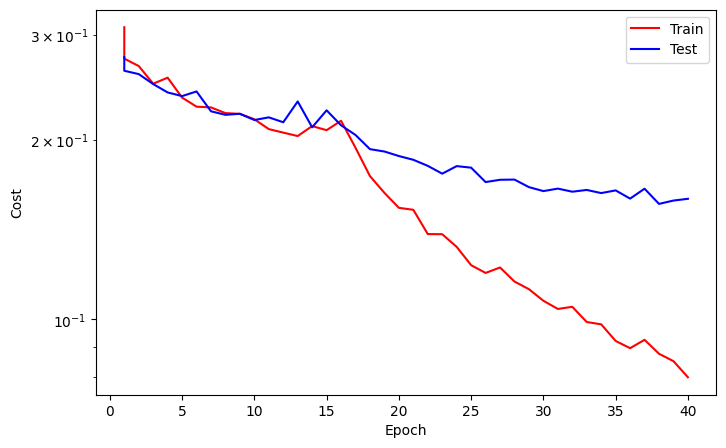

==> EarlyStop patience =  2 | Best test_cost: 0.1562


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0787 | Test_cost  = 0.1626 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1562


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.0773 | Test_cost  = 0.1597 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1562


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.0732 | Test_cost  = 0.1656 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1562
==> Execute Early Stopping at epoch: 43 | Best test_cost: 0.1562
==> Best model is saved at model


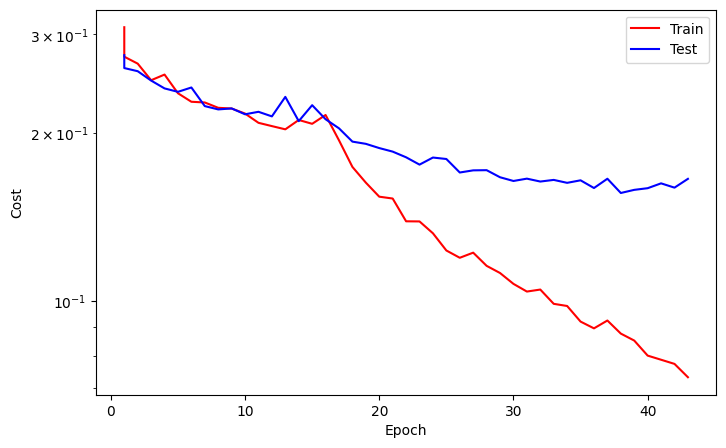

In [22]:
while True:
    train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break



# Predict

In [23]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [24]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float)
preds

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 1.],
        [1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0

# Sanity Check

In [25]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred == 1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] = 0.229 + 0.485
    img[1, :, :] = img[1, :, :] = 0.224 + 0.456
    img[2, :, :] = img[2, :, :] = 0.225 + 0.406
    return img

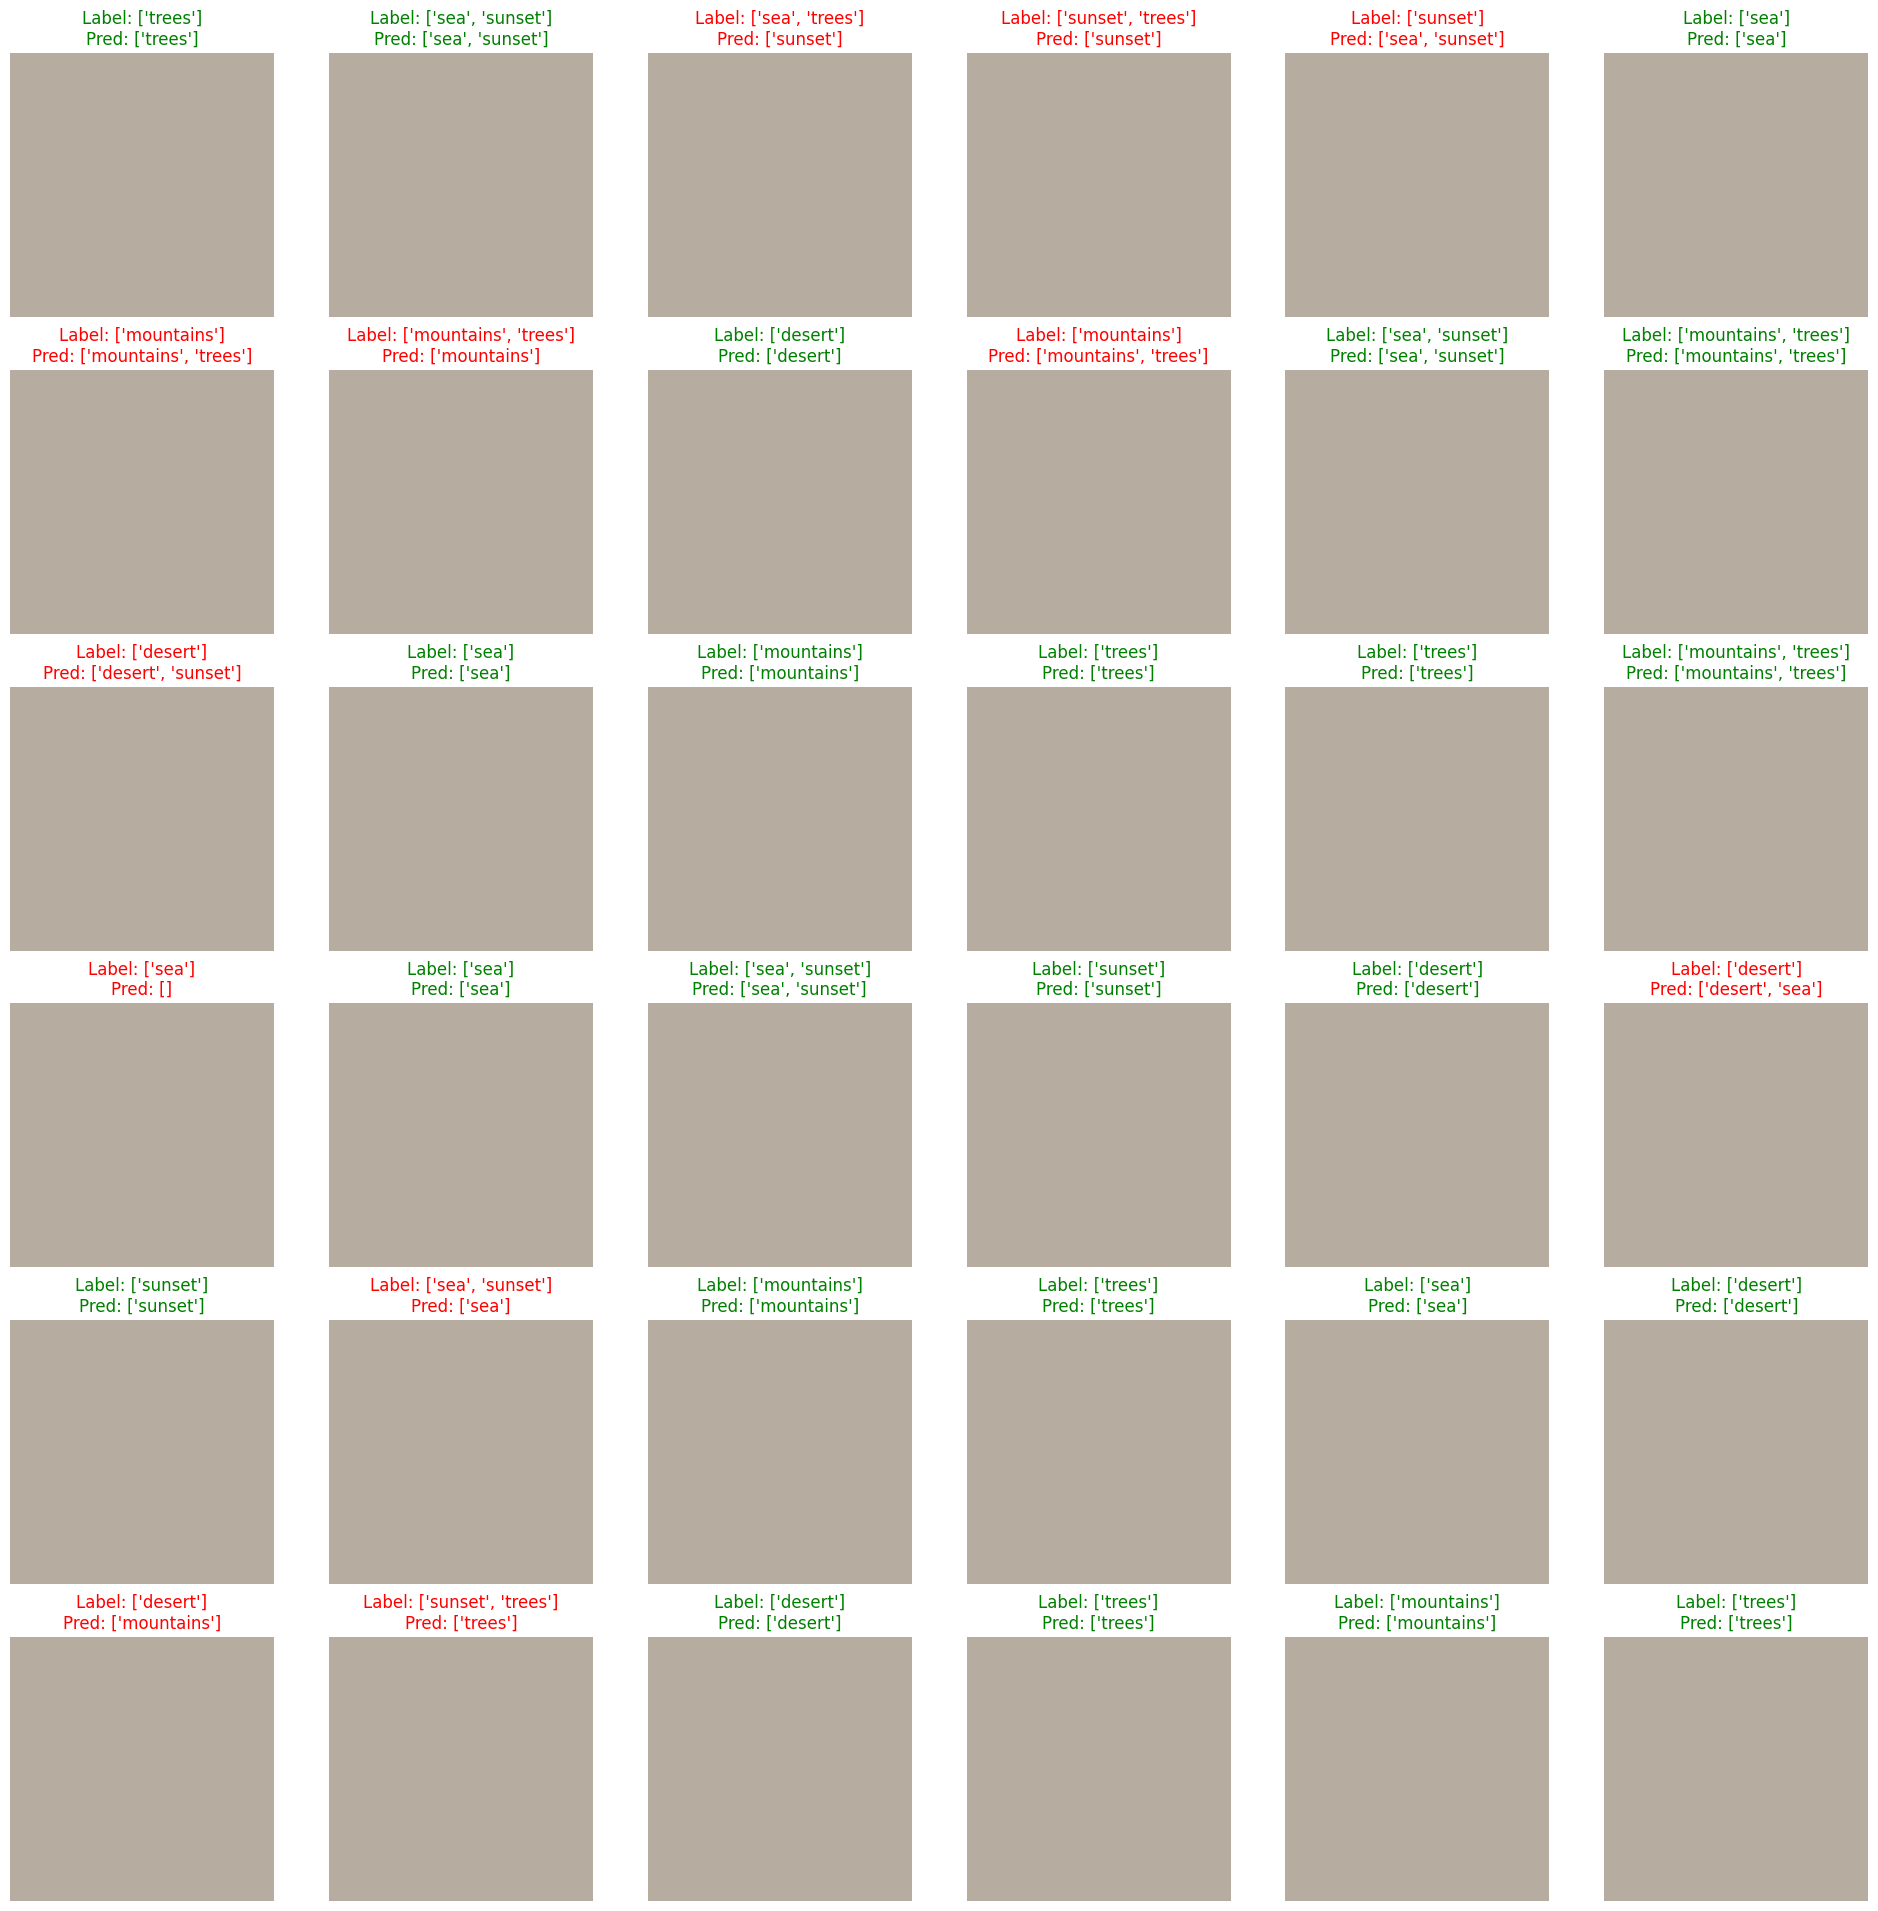

In [27]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": "r"} if (pred != label).any() else {"color": "g"}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
    ax.axis('off');


In [ ]:
img

tensor([[[0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         ...,
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140]],

        [[0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         ...,
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800]],

        [[0.6310, 0.6310, 0.6310,  ..., 0.6310, 0.6310, 0.6310],
         [0.6310, 0.6310, 0.6310,  ..., 0.6310, 0.6310, 0.6310],
         [0.6310, 0.6310, 0.6310,  ..., 0.6310, 0.6310, 0.

In [28]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/logs.pth (deflated 34%)
  adding: content/model/configs.pth (deflated 58%)
